### Load data and build matrices

In [1]:
cd ../../../../

/Users/archnnj/Development/recsys/recsys_polimi_challenge_2018/repo


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline
import scipy.sparse as sps
from scipy.stats import iqr
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

import src.utils.build_icm as build_icm
from src.utils.data_splitter import train_test_holdout, train_test_user_holdout, train_test_row_holdout

In [3]:
import sys
sys.path.append("src/libs/RecSys_Course_2018/") # go to parent dir

In [4]:
from SequenceAware.sars_tutorial_master.util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format

#### Global vars

In [5]:
JUPYTER = False

#### Load data

In [9]:
if JUPYTER:
    # Jupyter
    tracks_csv_file = "../../../data/tracks.csv"
    interactions_csv_file = "../../../data/train.csv"
    playlist_id_csv_file = "../../../data/target_playlists.csv"
    sequential_csv_file = "../../../data/train_sequential.csv"
else:
    # PyCharm
    tracks_csv_file = "data/tracks.csv"
    interactions_csv_file = "data/train.csv"
    playlist_id_csv_file = "data/target_playlists.csv"
    sequential_csv_file = "data/train_sequential.csv"

tracks_df = pd.read_csv(tracks_csv_file)
interactions_df = pd.read_csv(interactions_csv_file)
playlist_id_df = pd.read_csv(playlist_id_csv_file)
train_sequential_df = pd.read_csv(sequential_csv_file)

userList = interactions_df["playlist_id"]
itemList = interactions_df["track_id"]
ratingList = np.ones(interactions_df.shape[0])
targetsList = playlist_id_df["playlist_id"]
targetsListOrdered = targetsList[:5000].tolist()
targetsListCasual = targetsList[5000:].tolist()

userList_unique = pd.unique(userList)
itemList_unique = tracks_df["track_id"]
numUsers = len(userList_unique)
numItems = len(itemList_unique)
numberInteractions = interactions_df.size

In [10]:
URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all_csr = URM_all.tocsr()

In [11]:
itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity_unsorted = itemPopularity
itemPopularity = np.sort(itemPopularity)

#### Prepare ICM and URM with splits

In [12]:

# Build ICM
ICM_all = build_icm.build_icm(tracks_df, split_duration_lenght=800, feature_weights={'albums': 1, 'artists': 0.5, 'durations': 0.1})

IDF_ENABLED = True

if IDF_ENABLED:
    num_tot_items = ICM_all.shape[0]
    # let's count how many items have a certain feature
    items_per_feature = (ICM_all > 0).sum(axis=0)
    IDF = np.array(np.log(num_tot_items / items_per_feature))[0]
    ICM_idf = ICM_all.copy()
    # compute the number of non-zeros in each col
    # NOTE: this works only if X is instance of sparse.csc_matrix
    col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
    # then normalize the values in each col
    ICM_idf.data *= np.repeat(IDF, col_nnz)
    ICM_all = ICM_idf  # use IDF features

# #### Build URM

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all_csr = URM_all.tocsr()

URM_IDF_ENABLED = False

if URM_IDF_ENABLED:
    num_tot_items = URM_all.shape[0]
    # let's count how many items have a certain feature
    items_per_feature = (URM_all > 0).sum(axis=0)
    IDF = np.array(np.log(num_tot_items / items_per_feature))[0]
    URM_idf = URM_all.copy()
    # compute the number of non-zeros in each col
    # NOTE: this works only if X is instance of sparse.csc_matrix
    col_nnz = np.diff(sps.csc_matrix(URM_idf).indptr)
    # then normalize the values in each col
    URM_idf.data *= np.repeat(IDF, col_nnz)
    URM_all = URM_idf  # use IDF features

# #### Train/test split: ratings and user holdout

seed = 0
# ratings holdout
# URM_train, URM_test_pred = train_test_holdout(URM_all, train_perc=0.8, seed=seed)
# URM_valid=URM_test_pred
# URM_test_known = None

# user holdout
# URM_train, URM_test_known, URM_test_pred = train_test_user_holdout(URM_all, user_perc=0.8, train_perc=0.8, seed=seed)

# row holdout
URM_train, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8, seed=seed, targetsListOrdered=targetsListOrdered, nnz_threshold=10)
URM_test_known = None

# row holdout - validation
# URM_train_val, URM_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df, train_perc=0.8,
#                                                       seed=seed, targetsListOrdered=targetsListOrdered,
#                                                       nnz_threshold=10)
# URM_train, URM_valid = train_test_holdout(URM_train_val, train_perc=0.7, seed=seed)
# URM_test_known = None
# URM_train, URM_valid_test_pred = train_test_row_holdout(URM_all, userList_unique, train_sequential_df,
#                                                        train_perc=0.6,
#                                                        seed=seed, targetsListOrdered=targetsListOrdered,
#                                                        nnz_threshold=2)
# URM_valid, URM_test_pred = train_test_row_holdout(URM_valid_test_pred, userList_unique, train_sequential_df,
#                                                   train_perc=0.5,
#                                                  seed=seed, targetsListOrdered=targetsListOrdered,
#                                                  nnz_threshold=1)

URM_train = URM_train
#URM_validation = URM_valid
URM_test = URM_test_pred

### Utils

In [50]:
def get_sequences_df(URM, train_sequential_df, user_arr):
    sequences_arr = []
    for user_id in user_arr:
        URM_start_pos = URM.indptr[user_id]
        URM_end_pos = URM.indptr[user_id + 1]
        user_nnz = URM_end_pos - URM_start_pos
        
        if user_nnz > 0:
            original_order_items = np.array(
                train_sequential_df.loc[train_sequential_df['playlist_id'].isin([user_id])]['track_id'])
            original_order_items = np.array([i for i in original_order_items if i in URM.indices[URM_start_pos:URM_end_pos]]) # filter items in urm
            # original_order_items_sorted_i = original_order_items.argsort()
            sequences_arr.append({'user_id':user_id, 'sequence': original_order_items.tolist()})
    sequences = pd.DataFrame(sequences_arr)
    sequences = sequences[['user_id', 'sequence']]
    return sequences

#### Create Sequence

In [51]:
sequences = get_sequences_df(URM_all.tocsr(), train_sequential_df, targetsListOrdered)
train_sequences = get_sequences_df(URM_train, train_sequential_df, targetsListOrdered)
test_sequences = get_sequences_df(URM_test, train_sequential_df, targetsListOrdered)

In [52]:
sequences.head()

,user_id,sequence
0,7,"[12493, 17495, 13424, 7109, 14714, 15650, 1574..."
1,25,"[13805, 7035, 2336, 16663, 4720, 19967, 12384,..."
2,29,"[17056, 16912, 14907, 4148, 15430, 4543, 16387..."
3,34,"[16759, 9266, 13302, 18536, 8248, 523, 11656, ..."
4,50,"[14417, 19813, 5281, 6245, 2388, 13452, 153, 1..."


In [53]:
train_sequences.head()

,user_id,sequence
0,7,"[12493, 17495, 13424, 7109, 14714, 15650, 1574..."
1,25,"[13805, 7035, 2336, 16663, 4720, 19967, 12384,..."
2,29,"[17056, 16912, 14907, 4148, 15430, 4543, 16387..."
3,34,"[16759, 9266, 13302, 18536, 8248, 523, 11656, ..."
4,50,"[14417, 19813, 5281, 6245, 2388, 13452, 153, 1..."


In [54]:
test_sequences.head()

,user_id,sequence
0,7,"[8869, 13359, 15296, 17114, 3767, 5668, 15640]"
1,25,"[13637, 4910, 89]"
2,29,"[9003, 6606, 18669, 18904, 13364]"
3,34,"[3753, 6707, 19541, 10992, 18661, 14579]"
4,50,"[10496, 13757]"


#### Start of original notebook

In [55]:
cd src/libs/RecSys_Course_2018/SequenceAware/sars_tutorial_master

[Errno 2] No such file or directory: 'src/libs/RecSys_Course_2018/SequenceAware/sars_tutorial_master'
/Users/archnnj/Development/recsys/recsys_polimi_challenge_2018/repo/src/libs/RecSys_Course_2018/SequenceAware/sars_tutorial_master


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
from util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format
from util.split import last_session_out_split
from util.metrics import precision, recall, mrr, mean_average_precision
from util import evaluation
from recommenders_original.FSMRecommender import FSMRecommender

In [58]:
import datetime

In [59]:
def get_test_sequences(test_data, given_k):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
    return test_sequences

<a id='load_the_dataset'></a>

In [23]:
dataset = sequences

Let's see at how the dataset looks like

In [24]:
dataset.head()

,user_id,sequence
0,7,"[12493, 17495, 13424, 7109, 14714, 15650, 1574..."
1,25,"[13805, 7035, 2336, 16663, 4720, 19967, 12384,..."
2,29,"[17056, 16912, 14907, 4148, 15430, 4543, 16387..."
3,34,"[16759, 9266, 13302, 18536, 8248, 523, 11656, ..."
4,50,"[14417, 19813, 5281, 6245, 2388, 13452, 153, 1..."


Let's show ssome statistics about the dataset

In [25]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [26]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 13536
Number of users: 5000
Number of sessions: 5000

Session length:
	Average: 23.11
	Median: 20.0
	Min: 7
	Max: 75
Sessions per user:
	Average: 1.00
	Median: 1.0
	Min: 1
	Max: 1


In [27]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [(5606, 181), (10848, 160), (8956, 157), (15578, 153), (12393, 150)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset by assigning the **last session** of every user to the **test set**, and **all the previous** ones to the **training set**.

In [61]:
train_data = train_sequences
test_data = test_sequences

<a id='fitting'></a>

# 3. Fitting the recommender

Here we fit the recommedation algorithm over the sessions in the training set.

This algorithm extract Frequent Sequential Patterns from all the training sequences. Patterns are having support lower than `minsup` are discarded (support = # occurrences of a pattern in the traning data).  
Recommendations are then generated by looking for patterns having a _prefix_ corresponding to the last `[max_context, min_context]` elements in the user profile, taken in order. Matches are then sorted by decreasing _confidence_ score (ratio between the support of the matched rule and the support of the context). Matches having confidence below `minconf` are discarded.

The class `FSMRecommender` has the following initialization hyper-parameters:
* `minsup`: the minimum support threshold. It is interpreted as relative count if in \[0-1\], otherwise as an absolute count. NOTE: Relative count required for training with SPFM (faster).
* `minconf`: the minimum confidence threshold. Use to filter irrelevent recommendations.
* `max_context`: the maximum number of items in the user profile (starting from the last) that will be used for lookup in the database of frequent sequences.
* `min_context`: the minimum number of items in the user profile (starting from the last) that will be used for lookup in the database of frequent sequences.
* `spmf_path`: path to SPMF jar file. If provided, SPFM library will be used for pattern extraction (algorithm: Prefix Span). Otherwise, use pymining, which can be significantly slower depending on the sequence database size.
* `db_path`: path to the sequence database file


In [ ]:
# convert the training sequences to SPFM format first
db_path = 'tmp/sequences.txt'
sequences_to_spfm_format(train_data['sequence'].values, tmp_path=db_path)

In [69]:
# then we instantiate and fit the recommender
recommender = FSMRecommender(minsup=0.002, 
                             minconf=0.1, 
                             min_context=1, 
                             max_context=10,
                             spmf_path='spmf/spmf.jar',
                             db_path=db_path)
# calling fit() without arguments to use SPFM and the sequences stored in db_path
#recommender.fit()
# calling fit() with an argument will use pymining.seqmining for pattern extraction (slower, MANDATORY ON BIDNDER) 
recommender.fit(train_data)

2019-01-02 19:15:01,420 - INFO - Using pymining.seqmining (python) for Frequent Sequence Mining
2019-01-02 19:15:01,421 - INFO - Mining frequent sequences (minsup=10)
2019-01-02 19:15:16,590 - INFO - 3500 frequent sequences found
2019-01-02 19:15:16,591 - INFO - Building the prefix tree
2019-01-02 19:15:17,088 - INFO - Training completed


<a id='seq_evaluation'></a>


# 4. Sequential evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [74]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
           #'map': mean_average_precision}
TOPN=10 # length of the recommendation list

<a id='eval_seq_rev'></a>

## 4.1 Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

** (TODO) Try out with different evaluation settings to see how the recommandation quality changes. **


![](gifs/sequential_eval.gif)

In [75]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [76]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=True,  # scrolling averages metrics over all profile lengths
                                           step=STEP)

  0%|          | 15/4465 [00:00<00:29, 148.56it/s]

4465 sequences available for evaluation


100%|██████████| 4465/4465 [00:32<00:00, 138.93it/s]


In [77]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0043
	recall@10: 0.0110
	mrr@10: 0.0063


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

**(TODO) Try out with different evaluation settings to see how the recommandation quality changes.**

In [78]:
GIVEN_K = 1
LOOK_AHEAD = 'all'
STEP=1

In [79]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                          )  

  1%|          | 40/4465 [00:00<00:11, 397.09it/s]

4465 sequences available for evaluation


100%|██████████| 4465/4465 [00:08<00:00, 518.32it/s]


In [80]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=all, STEP=1)
	precision@10: 0.0082
	recall@10: 0.0070
	mrr@10: 0.0129


<a id='next-item'></a>

## 5. Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [81]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [82]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

4465 sequences available for evaluation


In [83]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

  0%|          | 16/4465 [00:00<00:30, 148.08it/s]

Evaluating recommendation lists with length: 1


  0%|          | 19/4465 [00:00<00:25, 176.45it/s]

Evaluating recommendation lists with length: 5


  0%|          | 19/4465 [00:00<00:25, 174.83it/s]

Evaluating recommendation lists with length: 10


  0%|          | 19/4465 [00:00<00:24, 181.11it/s]

Evaluating recommendation lists with length: 20


  0%|          | 19/4465 [00:00<00:24, 178.01it/s]

Evaluating recommendation lists with length: 50


  0%|          | 17/4465 [00:00<00:26, 169.39it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 4465/4465 [00:32<00:00, 136.54it/s]


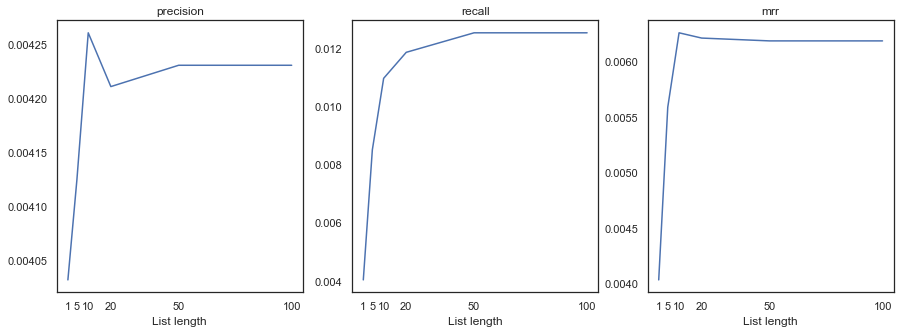

In [84]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

### 5.1.1 Evaluation for different recommendation list lengths

In [85]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1,2,3,4,5,6,7,8,9,10]

In [86]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

4465 sequences available for evaluation


In [87]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

  0%|          | 16/4465 [00:00<00:29, 151.55it/s]

Evaluating recommendation lists with length: 1


  0%|          | 19/4465 [00:00<00:25, 171.55it/s]

Evaluating recommendation lists with length: 2


  0%|          | 20/4465 [00:00<00:23, 185.89it/s]

Evaluating recommendation lists with length: 3


  0%|          | 20/4465 [00:00<00:23, 190.87it/s]

Evaluating recommendation lists with length: 4


  0%|          | 15/4465 [00:00<00:29, 149.11it/s]

Evaluating recommendation lists with length: 5


  0%|          | 20/4465 [00:00<00:24, 180.20it/s]

Evaluating recommendation lists with length: 6


  0%|          | 20/4465 [00:00<00:23, 189.67it/s]

Evaluating recommendation lists with length: 7


  0%|          | 20/4465 [00:00<00:23, 186.99it/s]

Evaluating recommendation lists with length: 8


  0%|          | 20/4465 [00:00<00:23, 187.89it/s]

Evaluating recommendation lists with length: 9


  0%|          | 17/4465 [00:00<00:26, 168.75it/s]

Evaluating recommendation lists with length: 10


100%|██████████| 4465/4465 [00:33<00:00, 125.40it/s]


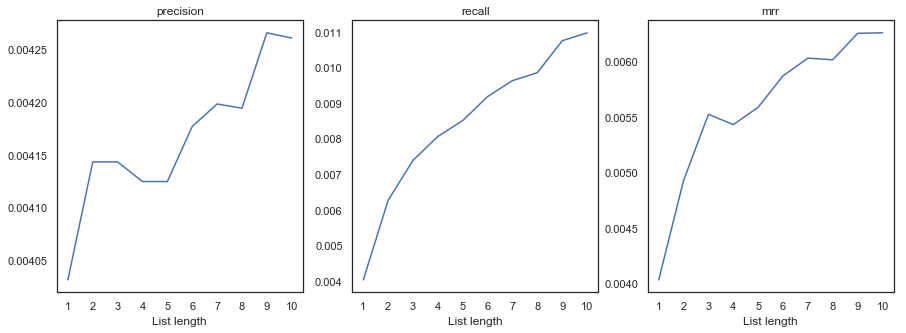

In [88]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [89]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 20

In [90]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, max(given_k_list))
print('{} sequences available for evaluation'.format(len(test_sequences)))

2139 sequences available for evaluation


In [91]:
res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=gk,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=TOPN,
                                               scroll=False,  # here we stop at each profile length
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

  3%|▎         | 57/2139 [00:00<00:03, 559.16it/s]

Evaluating profiles having length: 1


  1%|▏         | 29/2139 [00:00<00:07, 289.24it/s]

Evaluating profiles having length: 2


  1%|          | 19/2139 [00:00<00:11, 186.66it/s]

Evaluating profiles having length: 3


  0%|          | 4/2139 [00:00<01:04, 33.35it/s]

Evaluating profiles having length: 4


100%|██████████| 2139/2139 [00:17<00:00, 122.64it/s]


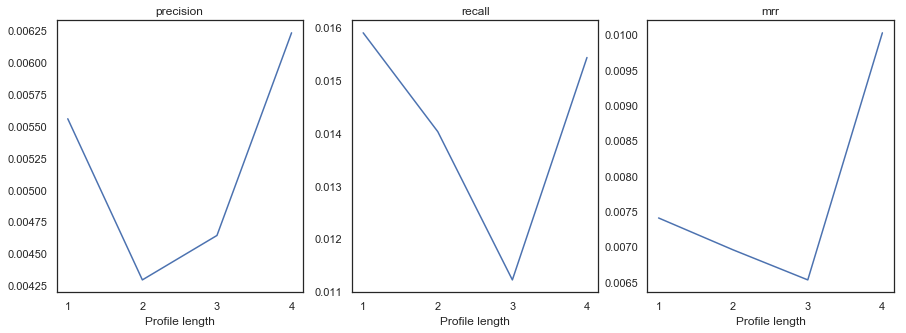

In [92]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')